We shall now build and train a Convolutional Neural Network on the augmented Oxford IIIT Pet Dataset.

In [2]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time

# Data loading

We shall use the Dataset class to build a custom dataset class inheriting from it.

In [3]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255    # not using read_image coz it can only read jpeg or png
        image = image[:,:,:3]  # dropping the alpha channel if any
        class_label = self.img_annotations.iloc[idx,2]-1      # the -1 is coz labels are expected from 0 to C-1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label

Let's define the transforms, read_image already reads the images as tensors so we don't need to use ToTensor, we shall only resize the images to (size,size) pixels. We shall use the NLL Loss later, this expects as target a class index ranging from 0 to C-1. So we don't need one-hot encoding for the target, but in principle we could do it as shown below. 

In [4]:
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize])     # totensor has to be applied first and then resize coz the latter doesn't work on numpy arrays
#label_transform_one_hot = T.Lambda(lambda y: torch.zeros(37, dtype=torch.float).scatter_(dim=0,index=torch.tensor(y),value=1))

In [5]:
train_r1 = PetDataset('annotations_aug/annotations_train_r1.csv','img_augmented_processed/', transform = trans)
train_r2 = PetDataset('annotations_aug/annotations_train_r2.csv','img_augmented_processed/', transform = trans)
train_r3 = PetDataset('annotations_aug/annotations_train_r3.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test.csv','img_augmented_processed/', transform = trans)

In [19]:
train_r1_loader = DataLoader(train_r1,batch_size=64,shuffle=True)
train_r2_loader = DataLoader(train_r2,batch_size=64,shuffle=True)
train_r3_loader = DataLoader(train_r3,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=64,shuffle=True)
test_loader = DataLoader(test,batch_size=64,shuffle=True)

We can call the first batch in the following way:

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


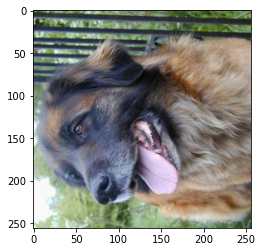

In [20]:
train_b1_img, train_b1_label = next(iter(train_r1_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model

In [26]:
class PetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
                                    nn.MaxPool2d(kernel_size=4,stride=2),
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential(
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential(
                                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential(
                                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential(
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential(
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv7 = nn.Sequential(
                                    nn.Conv2d(in_channels=256, out_channels=300, kernel_size=3),
                                    nn.BatchNorm2d(300),
                                    nn.ReLU())
        
        self.conv8 = nn.Sequential(
                                    nn.Conv2d(in_channels=300, out_channels=370, kernel_size=3),
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(
                                    nn.Linear(int(370*((size-240)/16)*((size-240)/16)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model = PetCNN()
loss_function = nn.NLLLoss()
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

print(model)
        

PetCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

In [29]:
# Trying to overtrain on just the first batch from set r1

train_r1_loader_temp = DataLoader(train_r1,batch_size=512,shuffle=True)
x = next(iter(train_r1_loader_temp))

count = 0

start = time.time()

#for i in range(num_epochs):
for i in range(400):
    model.train()
    
    out = model(x[0].float())
    loss = loss_function(out,x[1])
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    count += 1
    
    if count%20 == 0:
        
        end = time.time()
        print('Time taken for the last 20 iterations: {}'.format(end-start))        # time taken for the last 10 iterations
    
        model.eval()
        with torch.no_grad():
            out = model(x[0].float())
            current_loss = loss_function(out,x[1])
            print('Iteration:{}'.format(count))
            print(out)
            print('Loss:{}'.format(current_loss.item()))
            print('Accuracy:{}'.format((torch.max(out,1)[1]==x[1]).sum()/512))
            
        start = time.time()      
       
        

    


Time taken for the last 20 iterations: 93.08424139022827
Iteration:20
tensor([[-5.8831, -5.9534, -5.1005,  ..., -5.9046, -4.8790, -5.8845],
        [-5.2437, -4.9452, -5.6147,  ..., -5.9532, -5.3112, -6.2928],
        [-6.3431, -4.6896, -5.5351,  ..., -5.6721, -4.9527, -5.7409],
        ...,
        [-5.6094, -5.2034, -5.4552,  ..., -5.4803, -5.8504, -4.9039],
        [-6.4768, -6.0164, -5.0042,  ..., -7.0130, -5.4184, -5.2283],
        [-5.8768, -5.1712, -5.4299,  ..., -6.1425, -5.1425, -5.9768]])
Loss:0.19353783130645752
Accuracy:0.998046875
Time taken for the last 20 iterations: 101.988605260849
Iteration:40
tensor([[-5.9518, -6.0103, -5.1486,  ..., -5.9561, -4.9368, -5.9455],
        [-5.2728, -4.9966, -5.6718,  ..., -6.0034, -5.3557, -6.3601],
        [-6.3920, -4.7126, -5.5679,  ..., -5.7240, -5.0033, -5.7776],
        ...,
        [-5.6804, -5.2628, -5.5377,  ..., -5.5455, -5.9302, -4.9598],
        [-6.5367, -6.0642, -5.0702,  ..., -7.0579, -5.4626, -5.2736],
        [-5.9386, 

In [ ]:
model.train()    # set the model in training mode coz the batchnorm layer behaves differently when using in eval mode.
#num_epochs = 2

start = time.time()

#for i in range(num_epochs):
for i in range(3):
    for batch, (images, labels) in enumerate(train_r1_loader):
        out = model(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            print(name, param.grad.abs().sum())
    
        optimizer.step()
        

    
end = time.time()
print('Time taken: {}'.format(end-start))

In [53]:
model.eval()

with torch.no_grad():
    for i in range(3):
        for batch, (images, labels) in enumerate(train_r1_loader):
            out = model(images.float())
            print(out.shape)
            print(out)
            print(torch.max(out,1)[1]==labels)
                    

torch.Size([64, 37])
tensor([[-3.4769, -3.6114, -3.7782,  ..., -3.7756, -3.8338, -3.7196],
        [-3.9288, -3.3031, -3.7449,  ..., -3.2689, -3.8290, -3.7216],
        [-3.7165, -3.5637, -3.5228,  ..., -3.8171, -3.8171, -3.8171],
        ...,
        [-3.7071, -3.9172, -3.5013,  ..., -3.3719, -3.7449, -3.7363],
        [-4.0464, -3.4569, -3.3715,  ..., -3.3013, -3.4913, -3.7600],
        [-2.9723, -3.8592, -3.7981,  ..., -3.8592, -3.4748, -3.7963]])
tensor([False, False, False, False, False, False,  True, False, False, False,
        False, False, False,  True, False, False, False, False,  True, False,
        False,  True,  True, False, False, False, False, False, False, False,
        False, False,  True, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False,  True])
torch.Size([64, 37])
tensor([[-3.6328, -

torch.Size([64, 37])
tensor([[-3.6509, -3.7589, -3.7658,  ..., -3.5956, -3.7371, -3.7847],
        [-3.0732, -3.9041, -3.6798,  ..., -3.6019, -3.9041, -3.6283],
        [-4.0882, -3.1149, -3.9985,  ..., -3.4708, -3.8286, -4.0882],
        ...,
        [-3.4540, -3.6406, -3.5909,  ..., -3.6609, -3.7648, -3.7648],
        [-3.8940, -3.7125, -3.6169,  ..., -3.9408, -3.6952, -3.8775],
        [-4.0481, -2.8913, -4.0987,  ..., -3.1403, -3.7578, -3.7308]])
tensor([False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,  True,
        False, False, False,  True, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,  True,
        False, False, False, False, False,  True,  True, False,  True, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-3.6601, -

torch.Size([64, 37])
tensor([[-4.0785, -3.6814, -3.8560,  ..., -3.6368, -3.6532, -3.8679],
        [-4.0334, -3.9914, -3.6874,  ..., -3.2467, -3.7712, -3.5425],
        [-3.9827, -3.4677, -3.8021,  ..., -3.6883, -3.9852, -3.9852],
        ...,
        [-3.7782, -3.6136, -3.5722,  ..., -3.5489, -3.7782, -3.6534],
        [-3.7316, -3.5374, -3.6057,  ..., -3.2558, -3.9630, -3.4960],
        [-3.8488, -3.6357, -3.4736,  ..., -3.5273, -3.8137, -3.8488]])
tensor([False, False,  True, False, False, False,  True, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False,  True,  True, False,  True, False, False,  True, False, False,
        False, False, False, False, False,  True,  True, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
         True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-4.0691, -

torch.Size([64, 37])
tensor([[-4.2235, -2.7036, -3.9901,  ..., -3.6848, -4.2235, -4.0077],
        [-4.0171, -3.7942, -3.9853,  ..., -3.4280, -3.5169, -3.7394],
        [-3.3132, -3.7795, -3.5560,  ..., -3.6112, -3.6820, -3.7795],
        ...,
        [-3.8491, -3.7775, -3.7848,  ..., -3.4394, -4.0926, -4.0926],
        [-4.0702, -3.5328, -3.6616,  ..., -3.0786, -3.9580, -3.8178],
        [-3.3673, -3.7904, -3.4375,  ..., -3.7824, -3.7904, -3.7904]])
tensor([False, False,  True, False, False,  True,  True, False, False,  True,
        False, False, False, False, False,  True, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
         True, False,  True, False, False, False, False,  True, False,  True,
        False, False,  True,  True,  True, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,  True,
        False,  True, False, False])
torch.Size([64, 37])
tensor([[-4.2504, -

torch.Size([64, 37])
tensor([[-3.8930, -3.5540, -3.8930,  ..., -3.6743, -3.4921, -3.6976],
        [-3.8468, -3.7464, -3.6480,  ..., -3.5273, -3.8468, -3.7835],
        [-3.9920, -3.4569, -3.8260,  ..., -3.3548, -3.9920, -3.7680],
        ...,
        [-3.4600, -3.7626, -3.5317,  ..., -3.6234, -3.8085, -3.7892],
        [-3.5969, -3.6683, -3.8581,  ..., -3.8640, -3.6493, -3.8040],
        [-3.9852, -3.7644, -3.4720,  ..., -3.2825, -3.7836, -3.8775]])
tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False,  True,  True, False, False, False, False,  True,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-4.1262, -

torch.Size([64, 37])
tensor([[-3.7855, -3.7955, -3.8326,  ..., -3.6508, -3.6777, -3.6325],
        [-3.3648, -3.7360, -3.5572,  ..., -3.7999, -3.8116, -3.8116],
        [-3.7824, -3.7194, -3.7384,  ..., -3.5661, -3.6771, -3.5048],
        ...,
        [-3.9129, -3.3477, -3.5745,  ..., -3.9188, -3.9188, -3.6411],
        [-3.6759, -3.9707, -3.5094,  ..., -3.8714, -3.9707, -3.7975],
        [-3.6586, -3.9009, -3.8482,  ..., -3.2005, -3.9439, -3.8561]])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False,  True, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False,  True, False, False,
         True, False, False, False, False, False, False, False,  True,  True,
        False, False, False,  True])
torch.Size([64, 37])
tensor([[-3.9402, -

torch.Size([64, 37])
tensor([[-4.0322, -3.8809, -3.7671,  ..., -3.2165, -4.0169, -3.8566],
        [-3.5670, -3.5883, -3.8097,  ..., -3.7087, -3.7620, -3.5440],
        [-3.5061, -3.6613, -3.6034,  ..., -3.6363, -3.7271, -3.6699],
        ...,
        [-4.2939, -3.0724, -3.9894,  ..., -3.0760, -3.9688, -3.5316],
        [-3.8540, -3.2336, -3.8392,  ..., -3.7396, -3.7481, -3.7039],
        [-4.5205, -2.5590, -4.5205,  ..., -3.1352, -3.7578, -3.6791]])
tensor([ True, False, False, False,  True, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,  True,
        False, False, False, False, False,  True,  True, False, False, False,
        False, False, False, False, False,  True, False,  True, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-3.6612, -

torch.Size([64, 37])
tensor([[-3.4454, -3.7855, -3.6590,  ..., -3.7855, -3.7855, -3.7855],
        [-3.6826, -3.4971, -3.5749,  ..., -3.6343, -3.7747, -3.6169],
        [-4.1636, -3.4263, -3.7271,  ..., -3.0043, -3.6751, -3.6275],
        ...,
        [-3.9782, -3.1867, -3.6746,  ..., -3.3448, -3.9117, -3.7858],
        [-4.3609, -3.5116, -4.1732,  ..., -3.1663, -3.7882, -3.9622],
        [-4.0058, -3.5736, -3.9053,  ..., -3.6557, -3.8647, -3.4763]])
tensor([False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False,  True,  True,  True, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False,  True, False])
torch.Size([64, 37])
tensor([[-3.6598, -

torch.Size([64, 37])
tensor([[-3.5149, -3.6247, -3.6413,  ..., -3.8644, -3.8028, -3.7521],
        [-3.4510, -3.7724, -3.5727,  ..., -3.7724, -3.7724, -3.7724],
        [-4.1260, -3.7783, -3.4610,  ..., -2.8407, -4.1260, -3.7869],
        ...,
        [-3.4598, -3.7945, -3.6196,  ..., -3.6232, -4.0025, -3.8442],
        [-4.0081, -3.6764, -3.2910,  ..., -3.1101, -3.9624, -3.6727],
        [-4.3299, -3.8671, -3.9222,  ..., -2.4801, -4.0584, -3.9209]])
tensor([False, False, False,  True, False, False, False, False, False, False,
         True, False,  True,  True, False, False, False,  True, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False,  True,  True, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
         True, False, False, False,  True, False,  True,  True, False, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-4.0278, -

torch.Size([64, 37])
tensor([[-3.9036, -3.7578, -3.6580,  ..., -3.4843, -3.9050, -3.4594],
        [-4.0040, -3.7878, -3.6997,  ..., -3.2923, -4.0040, -3.9180],
        [-3.8015, -3.5217, -3.8918,  ..., -3.8918, -3.6451, -3.6415],
        ...,
        [-3.9025, -3.8484, -3.6360,  ..., -3.3844, -3.9033, -3.7950],
        [-3.2623, -3.7598, -3.6735,  ..., -3.7368, -3.7598, -3.6754],
        [-3.8743, -3.5076, -3.9750,  ..., -3.8479, -3.7029, -3.7556]])
tensor([False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False,  True, False, False, False,  True,
        False, False, False,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True, False,
        False, False, False,  True])
torch.Size([64, 37])
tensor([[-4.0242, -

torch.Size([64, 37])
tensor([[-4.0209, -3.5589, -3.9698,  ..., -3.9845, -3.7561, -3.8570],
        [-3.2155, -3.6440, -3.8220,  ..., -3.8220, -3.5266, -3.6861],
        [-3.3732, -3.6071, -3.7782,  ..., -3.8226, -3.7004, -3.7800],
        ...,
        [-3.9136, -3.8604, -3.7242,  ..., -3.2168, -3.9136, -3.7476],
        [-3.5124, -3.9100, -3.6046,  ..., -3.7188, -3.9100, -3.8167],
        [-3.6339, -3.0018, -3.5228,  ..., -3.9261, -3.7064, -3.8475]])
tensor([False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False,  True, False, False, False, False,  True,  True, False,
        False, False,  True, False,  True, False, False, False, False, False,
        False, False, False,  True])
torch.Size([64, 37])
tensor([[-3.8927, -

torch.Size([64, 37])
tensor([[-3.7624, -3.4348, -3.6117,  ..., -3.5386, -3.6578, -3.8108],
        [-3.8837, -3.6270, -3.8411,  ..., -3.1839, -3.4486, -3.5310],
        [-3.6331, -3.8374, -3.6137,  ..., -3.2762, -3.8374, -3.8374],
        ...,
        [-3.7195, -3.5698, -3.3392,  ..., -3.4060, -3.5497, -3.6386],
        [-3.5263, -3.6502, -3.5122,  ..., -3.7913, -3.7396, -3.8297],
        [-3.9872, -3.7322, -3.5136,  ..., -3.5810, -4.0728, -3.6421]])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True, False, False, False,
         True, False,  True,  True, False, False, False, False, False,  True,
        False, False, False, False, False, False, False,  True, False, False,
        False,  True, False, False, False,  True, False, False,  True,  True,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False])
torch.Size([64, 37])
tensor([[-3.5546, -

torch.Size([64, 37])
tensor([[-3.4897, -3.7556, -3.6191,  ..., -3.6565, -3.7556, -3.7556],
        [-4.0727, -3.7200, -3.8653,  ..., -3.4838, -4.0727, -3.7118],
        [-4.0418, -3.7909, -3.8010,  ..., -2.9156, -3.9558, -3.9103],
        ...,
        [-3.0885, -3.7843, -3.5938,  ..., -3.7843, -3.7843, -3.7843],
        [-3.1479, -3.8031, -3.6165,  ..., -3.8031, -3.5748, -3.7909],
        [-4.0440, -3.3815, -3.8344,  ..., -3.4711, -3.6349, -3.8642]])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False,  True, False, False, False, False, False, False,
         True,  True, False, False, False, False, False, False, False, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-3.6491, -

torch.Size([64, 37])
tensor([[-3.8623, -3.5393, -3.8465,  ..., -3.2995, -3.6192, -3.5679],
        [-4.2655, -4.2492, -3.5984,  ..., -3.6444, -4.0360, -4.0425],
        [-3.4262, -3.8907, -3.7557,  ..., -3.8907, -3.6292, -3.7664],
        ...,
        [-3.6075, -3.4676, -3.5214,  ..., -3.8695, -3.8695, -3.7537],
        [-3.4837, -3.9261, -3.5788,  ..., -3.6724, -3.7103, -3.4746],
        [-3.3249, -3.6687, -3.6791,  ..., -3.9729, -3.7354, -3.9985]])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False,  True, False,
        False, False, False, False, False, False,  True, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True, False, False, False, False,
        False, False, False,  True, False,  True, False, False, False, False,
         True, False, False, False])
torch.Size([64, 37])
tensor([[-3.6025, -

torch.Size([64, 37])
tensor([[-3.4303, -3.8203, -3.7451,  ..., -3.8612, -3.6011, -3.6813],
        [-3.4481, -3.6267, -3.4864,  ..., -3.7509, -3.7884, -3.6586],
        [-3.8633, -3.1962, -3.7623,  ..., -3.8659, -4.0135, -3.5820],
        ...,
        [-3.8885, -3.6090, -3.4619,  ..., -3.3751, -3.8124, -3.5876],
        [-3.8280, -3.8168, -3.8486,  ..., -3.3683, -3.7338, -3.6286],
        [-3.9300, -3.6355, -3.9125,  ..., -3.7436, -3.6274, -3.6597]])
tensor([False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False,  True, False,  True, False,  True,
        False, False, False, False,  True, False, False,  True, False,  True,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False,  True, False,  True, False, False, False, False,
        False,  True, False, False, False, False, False, False,  True, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-3.4191, -

torch.Size([64, 37])
tensor([[-4.2143, -3.4585, -3.9418,  ..., -3.2140, -3.8221, -3.9242],
        [-3.8385, -3.5003, -3.8039,  ..., -3.6928, -3.6418, -3.5598],
        [-3.9549, -3.5278, -3.9279,  ..., -4.0190, -4.0190, -3.6025],
        ...,
        [-3.5845, -3.7298, -3.6638,  ..., -3.7298, -3.7036, -3.7298],
        [-3.8466, -3.5067, -3.7297,  ..., -3.7556, -3.9097, -3.7946],
        [-4.0713, -3.5143, -3.7921,  ..., -3.6741, -3.9002, -4.0487]])
tensor([False,  True, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False,  True, False,
        False, False, False,  True,  True, False, False, False, False, False,
         True, False,  True,  True, False, False, False, False, False, False,
        False, False,  True, False, False, False,  True, False, False, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-3.7314, -

torch.Size([64, 37])
tensor([[-3.5197, -3.6590, -3.6180,  ..., -3.8490, -3.4544, -3.6761],
        [-3.4704, -3.7548, -3.5502,  ..., -3.7916, -3.7604, -3.7663],
        [-4.2850, -4.2850, -3.1333,  ..., -3.1976, -3.8028, -3.9308],
        ...,
        [-3.6424, -3.6283, -3.7449,  ..., -3.7435, -3.7665, -3.7279],
        [-3.4871, -3.7667, -3.5371,  ..., -3.8299, -3.8299, -3.8299],
        [-4.1365, -3.0619, -4.1215,  ..., -4.1365, -3.9831, -3.2720]])
tensor([ True, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False,  True, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-4.1273, -

torch.Size([64, 37])
tensor([[-4.1353, -3.8108, -3.7866,  ..., -3.0270, -4.1353, -3.6735],
        [-4.3447, -3.2771, -4.0225,  ..., -3.0888, -4.2575, -3.5302],
        [-3.2669, -3.7311, -3.6094,  ..., -3.7915, -3.8086, -3.8256],
        ...,
        [-4.0342, -3.4571, -3.9377,  ..., -3.9950, -3.7576, -3.8142],
        [-3.0389, -3.8113, -3.6974,  ..., -3.8113, -3.6673, -3.7288],
        [-3.4508, -3.8202, -3.4502,  ..., -3.6786, -3.8219, -3.7840]])
tensor([ True, False, False, False,  True,  True, False, False,  True, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False,  True, False, False,
         True, False, False, False, False, False, False, False, False, False,
         True, False, False, False,  True, False,  True, False, False, False,
         True, False, False, False, False,  True, False,  True, False, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-3.9148, -

torch.Size([64, 37])
tensor([[-3.8217, -3.8931, -3.8323,  ..., -3.6263, -3.8480, -3.7182],
        [-3.6304, -3.6981, -3.7737,  ..., -3.8460, -3.7110, -3.7126],
        [-3.7241, -3.4476, -3.4611,  ..., -3.7581, -3.9029, -3.4830],
        ...,
        [-4.0650, -3.3997, -3.6271,  ..., -2.8799, -4.0650, -3.6896],
        [-3.6156, -3.6207, -3.6469,  ..., -3.7400, -3.9956, -3.5769],
        [-3.8624, -3.4389, -3.6267,  ..., -3.1813, -3.8608, -3.5585]])
tensor([False, False, False,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-4.0162, -

torch.Size([64, 37])
tensor([[-3.8430, -3.6669, -3.8731,  ..., -3.8731, -3.7497, -3.8580],
        [-3.6051, -3.5275, -3.8147,  ..., -3.4340, -3.8396, -3.3801],
        [-3.1926, -3.6904, -3.6323,  ..., -3.7672, -3.7672, -3.7578],
        ...,
        [-3.6697, -3.7690, -3.4958,  ..., -3.2071, -3.8052, -3.7307],
        [-3.9105, -3.6259, -3.8126,  ..., -3.0797, -3.8610, -3.9105],
        [-3.9021, -3.5501, -3.7280,  ..., -3.6257, -3.8227, -3.7433]])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False,  True, False, False, False, False,  True, False, False,  True,
        False, False, False, False, False, False, False, False,  True,  True,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,  True,
         True, False, False, False])
torch.Size([64, 37])
tensor([[-4.0389, -

torch.Size([64, 37])
tensor([[-3.3912, -3.5917, -3.6991,  ..., -3.8596, -3.7098, -3.8052],
        [-3.8764, -3.4302, -3.9121,  ..., -3.7210, -3.8122, -3.7876],
        [-4.0266, -3.1862, -3.4994,  ..., -3.3299, -3.8541, -3.7758],
        ...,
        [-4.1138, -4.0647, -3.6611,  ..., -3.3894, -4.1138, -3.8303],
        [-3.5326, -3.8194, -3.7425,  ..., -3.7359, -3.8887, -3.7374],
        [-4.0018, -3.5641, -3.8143,  ..., -3.6820, -3.9835, -3.5365]])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True,  True, False, False, False,  True, False, False,  True,
        False, False,  True,  True, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
         True, False,  True, False])
torch.Size([64, 37])
tensor([[-2.9981, -

torch.Size([64, 37])
tensor([[-3.6142, -3.5871, -3.6314,  ..., -3.5915, -3.7826, -3.7826],
        [-4.0468, -3.4821, -3.7300,  ..., -3.3773, -3.8535, -3.7917],
        [-3.5109, -3.8645, -3.9327,  ..., -3.8150, -3.9327, -3.5299],
        ...,
        [-4.2168, -3.8163, -4.1107,  ..., -2.9503, -4.1773, -3.9105],
        [-3.4032, -3.7492, -3.6489,  ..., -3.7492, -3.7492, -3.7492],
        [-3.3885, -3.8345, -3.6894,  ..., -3.8725, -3.7685, -3.7544]])
tensor([False,  True, False,  True, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,  True,
        False, False, False,  True, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False,  True, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-3.8904, -

torch.Size([64, 37])
tensor([[-3.8828, -3.8828, -3.5750,  ..., -3.1127, -3.8828, -3.7859],
        [-3.5372, -3.8151, -3.6535,  ..., -3.8671, -3.8671, -3.5596],
        [-3.7552, -3.6585, -3.6454,  ..., -2.9755, -3.7833, -3.5502],
        ...,
        [-5.6834, -4.8378, -4.3663,  ..., -2.4450, -5.6834, -4.7202],
        [-4.1728, -3.0485, -3.7921,  ..., -3.4009, -4.0259, -3.9336],
        [-3.9566, -3.5888, -3.8818,  ..., -2.7617, -3.9368, -3.6559]])
tensor([ True, False,  True, False,  True, False, False,  True, False, False,
        False, False,  True, False,  True, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-3.5835, -

torch.Size([64, 37])
tensor([[-4.1690, -3.6851, -3.8708,  ..., -3.3391, -3.8023, -3.6280],
        [-3.6394, -3.8542, -3.7943,  ..., -3.6739, -3.8542, -3.8542],
        [-3.3828, -3.6222, -3.8557,  ..., -3.8557, -3.8557, -3.5708],
        ...,
        [-3.1679, -3.7873, -3.7873,  ..., -3.7873, -3.6255, -3.6161],
        [-3.5320, -3.8107, -3.7363,  ..., -3.7856, -3.6400, -3.7737],
        [-3.4643, -3.7592, -3.7482,  ..., -3.4587, -3.8463, -3.8488]])
tensor([False, False,  True, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False,  True,  True, False,  True, False,  True,
        False,  True, False, False, False, False, False, False,  True, False,
        False, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-3.2417, -

torch.Size([64, 37])
tensor([[-4.0101, -3.1357, -3.5140,  ..., -3.3364, -4.0101, -3.7473],
        [-3.8281, -3.6938, -3.8720,  ..., -3.8720, -3.8720, -3.8132],
        [-3.9703, -3.6061, -3.3750,  ..., -3.0302, -3.9703, -3.8174],
        ...,
        [-3.3829, -3.7163, -3.6478,  ..., -3.7536, -3.7536, -3.7536],
        [-3.6072, -3.5163, -3.7765,  ..., -3.6627, -3.9152, -3.7156],
        [-3.7365, -3.4624, -3.9023,  ..., -3.9023, -3.7385, -3.8637]])
tensor([False,  True, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-4.1876, -

torch.Size([64, 37])
tensor([[-3.9136, -3.6674, -3.5826,  ..., -3.3084, -4.0364, -3.7524],
        [-3.6674, -3.9835, -3.6313,  ..., -3.3719, -3.8092, -3.5358],
        [-3.8649, -3.4569, -3.8697,  ..., -3.6759, -3.3874, -3.8241],
        ...,
        [-3.8095, -3.7438, -3.7858,  ..., -3.6546, -3.7273, -3.6568],
        [-4.4488, -3.8456, -4.0149,  ..., -2.8328, -4.0736, -4.0836],
        [-4.0678, -2.9568, -3.5468,  ..., -3.8437, -3.8543, -3.5815]])
tensor([False, False, False,  True, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False,  True, False, False, False, False,
         True, False,  True,  True, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False,  True, False, False, False, False, False,
        False, False,  True, False])
torch.Size([64, 37])
tensor([[-4.0843, -

torch.Size([64, 37])
tensor([[-3.6264, -3.6930, -3.8375,  ..., -3.8375, -3.7500, -3.7343],
        [-3.9503, -3.4730, -3.8465,  ..., -3.2762, -3.7748, -3.9142],
        [-3.9555, -3.5661, -3.8103,  ..., -3.8268, -3.7577, -3.7892],
        ...,
        [-4.0493, -3.4148, -3.7438,  ..., -3.2200, -4.0493, -3.6134],
        [-3.8503, -3.5332, -3.8750,  ..., -3.9111, -3.7665, -3.6989],
        [-4.0180, -4.0238, -4.0002,  ..., -3.6325, -4.0146, -3.8292]])
tensor([False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False,  True, False,
        False,  True, False, False, False, False, False, False, False,  True,
        False, False,  True,  True, False,  True, False, False, False, False,
        False, False, False,  True, False, False,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False])
torch.Size([64, 37])
tensor([[-3.5072, -

torch.Size([64, 37])
tensor([[-2.7690, -3.8300, -3.6633,  ..., -3.8300, -3.7917, -3.8300],
        [-4.1857, -3.2674, -3.4702,  ..., -3.1018, -4.1857, -3.7987],
        [-3.3081, -3.8670, -3.8445,  ..., -3.8670, -3.7903, -3.8670],
        ...,
        [-3.8893, -3.8099, -3.7948,  ..., -3.3567, -3.8893, -3.8893],
        [-3.3931, -3.4160, -3.7211,  ..., -3.9150, -3.7449, -3.7105],
        [-3.7892, -3.7197, -3.6841,  ..., -3.6643, -3.8738, -3.6245]])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,  True,
        False, False, False, False, False,  True, False,  True, False, False,
        False, False, False, False, False, False, False, False, False,  True,
         True,  True, False, False])
torch.Size([64, 37])
tensor([[-4.1838, -

KeyboardInterrupt: 